In [1]:
%pip install pandas==1.5.1 
%pip install swifter
%pip install emoji==1.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 19.9 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 6.4 MB/s 
     |████████████████████████████████| 280 kB 43.9 MB/s 
     |████████████████████████████████| 1.6 MB 46.6 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=dec04481755bc9ea6a47af91e75f873874f4552d3d49afb2269f8c24c2f8600e
  Stored in directory: /root/.cache/pip/wheels/08/66/b4/921e351e63d88696932279d6163e125727c9da70ed8ca38419
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully unins

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 29.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=52539585dcdaf0594958b98a9804129e429b0279d45c13625cffbc9d828e9ea1
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gc
import numpy as np
import datetime
import re
import swifter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as pl
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Useful functions

In [3]:
def accuracy(y_true,y_pred):
  assert len(y_true)==len(y_pred)
  return (y_true==y_pred).sum()/len(y_true)

def evaluate_model(X_train,y_train,X_test,y_test,model,metric='MSE'):
  predictions_test=model.predict(X_test)
  predictions_train=model.predict(X_train)
  if metric=='MSE':
    print('Mean squared error on train set: {:.3f}'.format(mean_squared_error(y_train,predictions_train)))
    print('Mean squared error on test set: {:.3f}'.format(mean_squared_error(y_test,predictions_test)))
  if metric=='accuracy':
    print('Accuracy on train set: {:.3f}'.format(accuracy(y_train,predictions_train)))
    print('Accuracy on test set: {:.3f}'.format(accuracy(y_test,predictions_test)))

def encode_and_bind(original_dataframe, features_to_encode):    
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)

def subs_cat(x):
  if x<100:
    return 0
  elif x<1000:
    return 1
  elif x<10000:
    return 2
  elif x<100000:
    return 3
  else:
    return 4

def model_fit_features(model,X_train,y_train,X_test,y_test,metric):
  model.fit(X_train,y_train)
  feature_importances = list(zip(X_train, model.feature_importances_))
  # Then sort the feature importances by most important first
  feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)

  # Plot the top 25 feature importance
  feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
  y_ticks = np.arange(0, len(feature_names_25))
  x_axis = [i[1] for i in feature_importances_ranked[:25]]
  plt.figure(figsize = (10, 14))
  sns.barplot(x_axis,feature_names_25,orient='h')      #horizontal barplot
  plt.title('Random Forest Feature Importance (Top 25)',
            fontdict= {'fontsize' : 20})
  plt.xlabel('Features',fontdict= {'fontsize' : 16})
  plt.show()
  evaluate_model(X_train,y_train,X_test,y_test,model,metric=metric)

# Loading the data

In [4]:
DATA='/content/drive/MyDrive/Data/'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%time
metadata_sample = pd.read_parquet(DATA + "df_metadata_sample_clean.parquet.gzip",engine='pyarrow')

CPU times: user 10.7 s, sys: 3.72 s, total: 14.4 s
Wall time: 17.6 s


In [6]:
metadata_sample.head()

,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,subs_before_video,tags_count,num_comms,description,title,virality,title_positive,title_negative,title_length,description_length
0,676973,Gaming,UCrnftLporTV1YgYbVi7GFsw,31,TqLn2hX6zoA,655,314,2019-03-13,45868.0,30595.541667,15,39.0,Send me your submissions to be featured https:...,Twitch Stream Fails and Epic Moments Compilati...,1.039202,0,1,52,296
1,66343748,Sports,UC2EuJ9xTs0XkDZI9YGx7QZA,51,MCEQL6g5EIU,614,468,2017-03-25,29088.0,20086.343750,15,179.0,If Floyd Mayweather vs. Conor McGregor ends up...,Conor McGregor's Best Asset: Undermining Doubt...,1.037371,1,3,63,599
2,12315685,Entertainment,UCiJfiEg1FImWsVuEu0L8X6Q,1,l3_IlJr-8_U,30,44,2016-08-18,11506.0,126756.750000,8,0.0,Watch Srirastu Subhamastu telugu movie dailogu...,Srirastu Subhamastu Latest Teaser | Allu Siris...,0.795803,0,0,93,439
3,29036231,People & Blogs,UCVptfwYcLxRED8w4Efy0CsA,88,y126khD2Q5k,373,1788,2016-04-05,189885.0,2942.500000,41,125.0,COACHING & TRAINING PLANS\nVisit harryruns.com...,Interval Training: How To Become a Faster Runner,1.521678,1,0,48,1044
4,56543085,Film & Animation,UCAP57cF-FSjJKzzXg7ntPlQ,0,JCuwthnCRpg,120,380,2019-01-08,7559.0,130292.885417,1,23.0,Now in theatres!,STALKER - Janus Films Trailer,0.758276,0,0,29,16


In [7]:
metadata_sample['virality']=metadata_sample['view_count'].apply(lambda x :np.log(x+1))/metadata_sample['subs_before_video'].apply(lambda x:np.log(x+1))

In [8]:
print('The top 95% of videos in terms of virality have a virality index of {:.4f}'.format(np.quantile(metadata_sample['virality'],0.95)))

The top 95% of videos in terms of virality have a virality index of 1.2095


In [9]:
metadata_viral=metadata_sample[metadata_sample['virality']>=np.quantile(metadata_sample['virality'],0.95)]
metadata_viral=metadata_viral.reset_index(drop=True)

In [10]:
metadata_sample['is_viral']=(metadata_sample['virality']>=np.quantile(metadata_sample['virality'],0.95)).apply(lambda x: 1 if x else 0)

In [11]:
metadata_sample['subs_cat']=metadata_sample['subs_before_video'].apply(lambda x:subs_cat(x))
metadata_sample['subs_cat']=metadata_sample['subs_cat'].astype('category')


In [ ]:
metadata_sample['virality']

# Random Forest Preprocesing

In [ ]:
metadata_sample.columns

Index(['index', 'categories', 'channel_id', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count',
       'subs_before_video', 'tags_count', 'num_comms', 'description', 'title',
       'virality', 'title_positive', 'title_negative', 'title_length',
       'description_length', 'is_viral', 'subs_cat'],
      dtype='object')

In [ ]:
features=[ 'categories',
       'duration', 
       'tags_count', 
        'title_positive', 'title_negative', 'title_length',
       'description_length','subs_cat']
cat_features=['categories','subs_cat']
y_cl=metadata_sample['is_viral']
y_reg=metadata_sample['virality']

In [ ]:
X=encode_and_bind(metadata_sample[features],cat_features)
X.head()

,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_Nonprofits & Activism,...,subs_cat_1,subs_cat_2,subs_cat_3,subs_cat_4,duration,tags_count,title_positive,title_negative,title_length,description_length
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,655,15,0,1,52,296
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,614,15,1,3,63,599
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,30,8,0,0,93,439
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,373,41,1,0,48,1044
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,120,1,0,0,29,16


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y_cl,test_size=0.333)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(838465, 27) (838465,) (418604, 27) (418604,)


# Random Forest Classifier

In [ ]:
model=RandomForestClassifier(n_estimators=10)

In [ ]:
%%time
model.fit(X_train,y_train)

CPU times: user 24.1 s, sys: 151 ms, total: 24.3 s
Wall time: 24.5 s


RandomForestClassifier(n_estimators=10)

In [ ]:
feature_importances = list(zip(X_train, model.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: duration                            Importance: 0.23751720074308375
Feature: description_length                  Importance: 0.22969454857395485
Feature: title_length                        Importance: 0.18037311379371246
Feature: tags_count                          Importance: 0.12129730818181658
Feature: subs_cat_1                          Importance: 0.05293010515575734
Feature: subs_cat_0                          Importance: 0.03257314255191847
Feature: subs_cat_4                          Importance: 0.03103814197320221
Feature: subs_cat_3                          Importance: 0.02066967741935034
Feature: title_positive                      Importance: 0.020053472279225867
Feature: title_negative                      Importance: 0.018826733545270553
Feature: subs_cat_2                          Importance: 0.01648966746630707
Feature: categories_People & Blogs           Importance: 0.004094450399636197
Feature: categories_Entertainment            Importance: 0.00390319728933

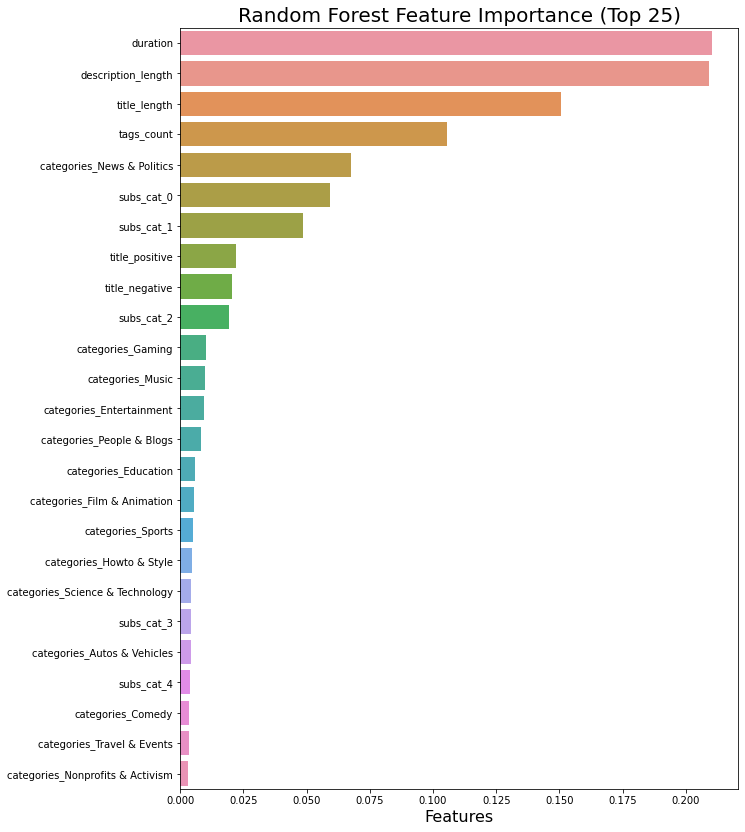

In [ ]:
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
sns.barplot(x_axis,feature_names_25,orient='h')   
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [ ]:
evaluate_model(X_train,y_train,X_test,y_test,model,metric='accuracy')

Accuracy on train set: 0.992
Accuracy on test set: 0.951


In [ ]:
#metadata_sample.to_parquet(DATA + "df_metadata_sample_clean.parquet.gzip",compression='gzip') 

# Random forest regressor

In [ ]:
X=encode_and_bind(metadata_sample[features],cat_features)
X.head()

,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_Nonprofits & Activism,...,subs_cat_1,subs_cat_2,subs_cat_3,subs_cat_4,duration,tags_count,title_positive,title_negative,title_length,description_length
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,655,15,0,1,52,296
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,614,15,1,3,63,599
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,30,8,0,0,93,439
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,373,41,1,0,48,1044
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,120,1,0,0,29,16


(838465, 27) (838465,) (418604, 27) (418604,)


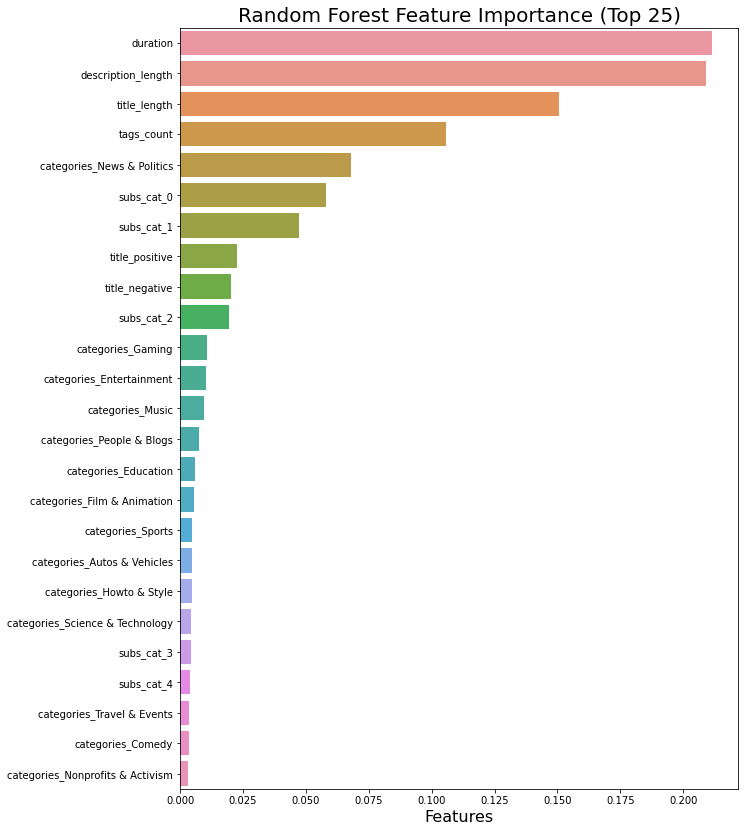

Mean squared error on train set: 0.010
Mean squared error on test set: 0.054
CPU times: user 1min 43s, sys: 1.29 s, total: 1min 44s
Wall time: 1min 46s


,prediction,true_value
0,0.806684,0.621983
1,0.940129,0.859073
2,0.618136,0.502657
3,0.978575,0.752578
4,0.949065,0.556464
...,...,...
418599,0.856486,0.960600
418600,0.568713,0.423659
418601,0.550659,0.404070
418602,0.588165,0.573394


In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X,y_reg,test_size=0.333)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
model=RandomForestRegressor(n_estimators=10)
model_fit_features(model,X_train,y_train,X_test,y_test,'MSE')
temp=pd.DataFrame(np.array([model.predict(X_test),y_test.values]).T,columns=['prediction','true_value'])
temp

In [ ]:
mean_squared_error(np.mean(y_test)*np.ones(len(y_test)),y_test)

0.07312700916559353

(838465, 27) (838465,) (418604, 27) (418604,)


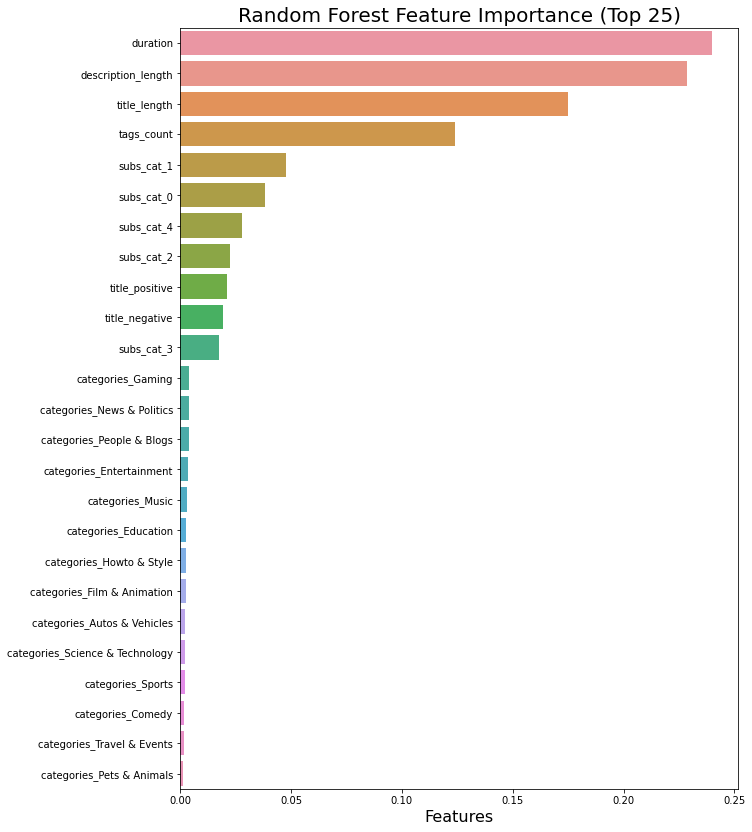

Accuracy on train set: 0.992
Accuracy on test set: 0.951
CPU times: user 30.6 s, sys: 108 ms, total: 30.7 s
Wall time: 31.7 s


In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X,y_cl,test_size=0.333)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
model=RandomForestClassifier(n_estimators=10)
model_fit_features(model,X_train,y_train,X_test,y_test,'accuracy')

In [ ]:
temp=pd.DataFrame(np.array([model.predict(X_test),y_test.values]).T,columns=['prediction','true_value'])
temp

,prediction,true_value
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
418599,0,0
418600,0,0
418601,0,0
418602,0,0


In [ ]:
accuracy(y_test,np.zeros(len(y_test)))

0.9498404219739898